# 基于回归分析的大学综合得分预测


使用来自 Kaggle 的[数据](https://www.kaggle.com/mylesoneill/world-university-rankings?select=cwurData.csv)，构建「线性回归」模型，根据大学各项指标的排名预测综合得分。

**基本要求：**
* 按照 8:2 随机划分训练集测试集，用 RMSE 作为评价指标，得到测试集上线性回归模型的 RMSE 值；
* 对线性回归模型的系数进行分析。

**扩展要求：**
* 对数据进行观察与可视化，展示数据特点；
* 尝试其他的回归模型，对比效果；
* 尝试将离散的国家特征融入线性回归模型，并对结果进行对比。

**注意事项：**
* 基本输入特征有 8 个：`quality_of_education`, `alumni_employment`, `quality_of_faculty`, `publications`, `influence`, `citations`, `broad_impact`, `patents`；
* 预测目标为`score`；
* 可以使用 sklearn 等第三方库，不要求自己实现线性回归；
* 需要保留所有数据集生成、模型训练测试的代码；

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor

import seaborn as sns

In [2]:
%matplotlib inline

## 参考文献

* *清华张敏老师机器学习课程*
* https://scikit-learn.org/stable/modules/outlier_detection.html
* *https://www.cnblogs.com/SevnChen/p/5065984.html*
* *https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html*

## 线性模型

### 多元线性回归模型

多元线性回归$$y = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n = \Theta^TX$$

根据最小二乘定理，求得参数$\Theta$ $$\Theta = (X^T X)^{-1}X^T y$$

线性回归模型实现：

In [3]:
class MyLinearRegression(object):
    
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        n_samples = len(X)
        # argument dataset, insert np.ones(n_smaples) column
        X = np.concatenate((np.ones(n_samples).reshape(-1, 1), X), axis=1)

        theta = np.linalg.inv(X.T@X)@X.T@y
        self.coef_ = theta[1:]
        self.intercept_ = theta[0]
        
    def score(self, X, y):
        y_pred = self.predict(X)
        y_mean = np.mean(y)
        return 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y_mean) ** 2)
    
    def predict(self, X):
        theta = np.concatenate(([self.intercept_], self.coef_))
        X = np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1)
        y_pred = X@theta.reshape(-1, 1)
        return y_pred.reshape(-1)

### 测试模型

1. 生成数据，并划分成训练集和测试集
2. 拟合训练数据集
3. 使用`RMSE`指标在训练集评估模型 $RMSE = \sqrt{\frac{1}{m}\sum\limits_{i=1}^{n}(y_i - \hat y_i)^2}$，决定系数（或拟合优度）$R^2 = 1 - \frac{\sum_i(y_i - \hat y_i)^2}{\sum_i(y_i-\bar y)^2}$

生成数据集 $y = 2 + 3x_1 + 4x_2 + 5x_3$

In [4]:
def linear_func(x1, x2, x3):
    return 2 + 3*x1 + 4*x2 + 5*x3

In [5]:
n_samples = 1000

X = np.random.randint(0, 100, (n_samples, 3))
y = np.array([linear_func(*x) for x in X])

分割数据集

In [6]:
x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

线性模型拟合数据集

In [7]:
model = MyLinearRegression()
model.fit(x_train, y_train)

In [8]:
print('Coefficient: %s Intercept: %.4f' % (model.coef_, model.intercept_))

Coefficient: [3. 4. 5.] Intercept: 2.0000


`RMSE` & $R^2$评估模型

In [9]:
y_pred = model.predict(x_test)

print('RMSE: %.4f, Coefficient of determination: %.4f' % (np.sqrt(mean_squared_error(y_pred, y_test)),
                                                          model.score(x_test, y_test)))

RMSE: 0.0000, Coefficient of determination: 1.0000


(0.0, 1114.0)

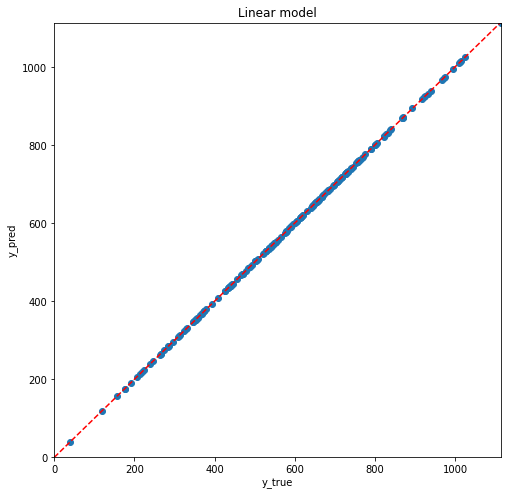

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], c='red', ls='--', transform=ax.transAxes)
plt.scatter(y_test, y_pred)

plt.title('Linear model')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))

### 模型优缺点

`来自张敏老师机器学习课程:`

优点:

1. 损失函数是严格凸函数，有唯一解
2. 求解过程简单，容易计算

缺点：

1. **结果对数据中的离群点outliner非常敏感。 解决方法：提前检测离群点并去除**
2. 损失函数对于超过和低于真实值的预测是等价的

**数据集中添加outlier，训练评估模型:**

In [11]:
X = np.random.randint(1, 100, (1000, 3))
y = np.array([linear_func(*x) for x in X])

for i in np.random.randint(0, len(X), 10):
    y[i] += np.random.randint(100, 1000)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = MyLinearRegression()
model.fit(x_train, y_train)

In [12]:
print('Intercept: %.4f, coefficients: %s' % (model.intercept_, model.coef_))

Intercept: 7.1904, coefficients: [3.06107908 3.945029   4.98841308]


In [13]:

y_pred = model.predict(x_test)
print('RMSE: %.4f, R2: %.4f' % (np.sqrt(mean_squared_error(y_pred, y_test)), model.score(x_test, y_test)))

RMSE: 58.0402, R2: 0.9316


(0.0, 1482.0)

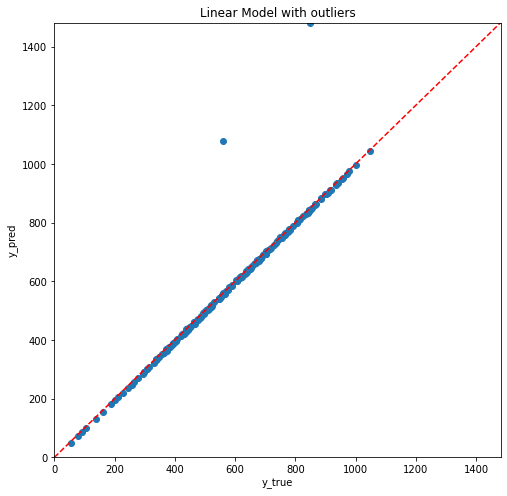

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='red')
plt.scatter(y_pred, y_test)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Linear Model with outliers')
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))

## Baseline

In [15]:
data_path = './data/cwurData.csv'

raw_df = pd.read_csv(data_path)
df = raw_df.copy()

In [16]:
df.head(3)

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012


In [17]:
df.head(3).T

,0,1,2
world_rank,1,2,3
institution,Harvard University,Massachusetts Institute of Technology,Stanford University
country,USA,USA,USA
national_rank,1,2,3
quality_of_education,7,9,17
alumni_employment,9,17,11
quality_of_faculty,1,3,5
publications,1,12,4
influence,1,4,2
citations,1,4,2


|特征|描述|
|---|----|
|quality_of_education|教学质量|
|alumni_employment|校友就业|
|quality_of_faculty|教师素质|
|publications|出版量|
|influence|影响力|
|citations|引用数量|
|broad_impact|广泛影响|
|patents|专利|

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   world_rank            2200 non-null   int64  
 1   institution           2200 non-null   object 
 2   country               2200 non-null   object 
 3   national_rank         2200 non-null   int64  
 4   quality_of_education  2200 non-null   int64  
 5   alumni_employment     2200 non-null   int64  
 6   quality_of_faculty    2200 non-null   int64  
 7   publications          2200 non-null   int64  
 8   influence             2200 non-null   int64  
 9   citations             2200 non-null   int64  
 10  broad_impact          2000 non-null   float64
 11  patents               2200 non-null   int64  
 12  score                 2200 non-null   float64
 13  year                  2200 non-null   int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 240.8+ KB


* 共有2200条记录
* 数据特征类型：2个类别特征，11个数据特征
* broad_impact特征存在缺失值

In [19]:
num_feats = ['quality_of_education', 'alumni_employment', 'quality_of_faculty', 'publications',
             'influence','citations', 'broad_impact', 'patents']

In [20]:
df.describe()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2000.000000,2200.000000,2200.000000,2200.000000
mean,459.590909,40.278182,275.100455,357.116818,178.888182,459.908636,459.797727,413.417273,496.699500,433.346364,47.798395,2014.318182
std,304.320363,51.740870,121.935100,186.779252,64.050885,303.760352,303.331822,264.366549,286.919755,273.996525,7.760806,0.762130
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.360000,2012.000000
25%,175.750000,6.000000,175.750000,175.750000,175.750000,175.750000,175.750000,161.000000,250.500000,170.750000,44.460000,2014.000000
50%,450.500000,21.000000,355.000000,450.500000,210.000000,450.500000,450.500000,406.000000,496.000000,426.000000,45.100000,2014.000000
75%,725.250000,49.000000,367.000000,478.000000,218.000000,725.000000,725.250000,645.000000,741.000000,714.250000,47.545000,2015.000000
max,1000.000000,229.000000,367.000000,567.000000,218.000000,1000.000000,991.000000,812.000000,1000.000000,871.000000,100.000000,2015.000000


In [21]:
df[['score']+num_feats].corr()

,score,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents
score,1.000000,-0.600541,-0.510374,-0.693540,-0.522111,-0.522837,-0.522438,-0.531590,-0.474810
quality_of_education,-0.600541,1.000000,0.606421,0.786181,0.624657,0.645641,0.630455,0.521615,0.528120
alumni_employment,-0.510374,0.606421,1.000000,0.558618,0.572096,0.527382,0.559200,0.423619,0.528219
quality_of_faculty,-0.693540,0.786181,0.558618,1.000000,0.634423,0.656406,0.652186,0.549345,0.555107
publications,-0.522111,0.624657,0.572096,0.634423,1.000000,0.874952,0.829912,0.917878,0.671558
influence,-0.522837,0.645641,0.527382,0.656406,0.874952,1.000000,0.845207,0.916040,0.611811
citations,-0.522438,0.630455,0.559200,0.652186,0.829912,0.845207,1.000000,0.852638,0.598728
broad_impact,-0.531590,0.521615,0.423619,0.549345,0.917878,0.916040,0.852638,1.000000,0.562861
patents,-0.474810,0.528120,0.528219,0.555107,0.671558,0.611811,0.598728,0.562861,1.000000


移除特征缺失数据

In [22]:
df = df.dropna()

相关性分析

In [23]:
sns.pairplot(df[['score']+num_feats])

世界排名`world_rank`与得分`score`的关系：

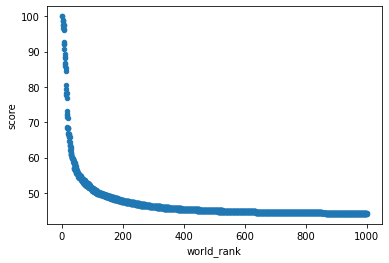

In [24]:
df[['score', 'world_rank']].plot.scatter(x='world_rank', y='score')

得分与教学质量`quality_of_education`的关系：

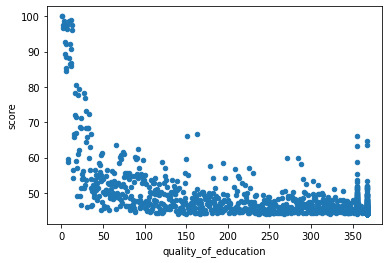

In [25]:
df[['score', 'quality_of_education']].plot.scatter(x='quality_of_education', y='score')

教学质量`quality_of_education`值越低，得分`score` 越高

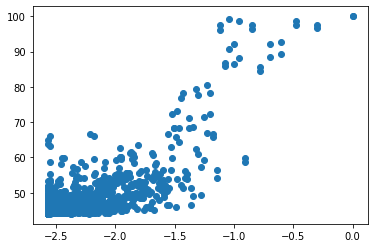

In [26]:
plt.scatter(-np.log10(df['quality_of_education']), df['score'])

进行$-log_{10}(x)$变换后，近似线性相关。

得分`score`与校友就业`alumni_employment`的关系:

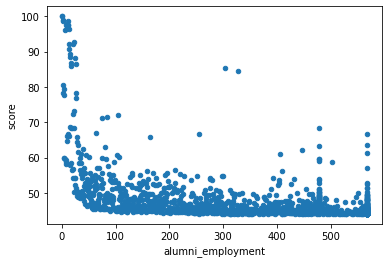

In [27]:
df[['score', 'alumni_employment']].plot.scatter(x='alumni_employment', y='score')

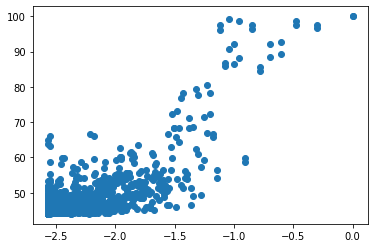

In [28]:
plt.scatter(-np.log10(df['quality_of_education']), df['score'])

进行$-log_{10}(x)$变换后，近似线性相关。

得分`score`与教师质量`quality_of_faculty`的关系：

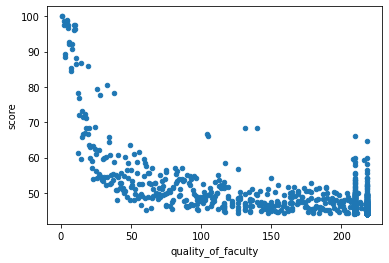

In [29]:
df[['score', 'quality_of_faculty']].plot.scatter(x='quality_of_faculty', y='score')

进行$-log_{10}(x)$变换后:

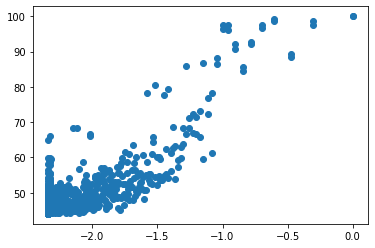

In [30]:
plt.scatter(-np.log10(df['quality_of_faculty']), df['score'])

得分`score`与初版量`publications`的关系：

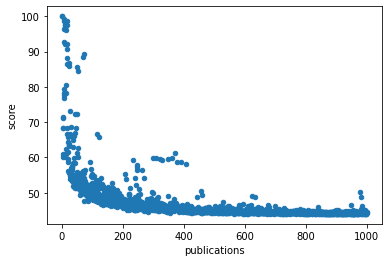

In [31]:
df[['score', 'publications']].plot.scatter(x='publications', y='score')

负对数变换后：

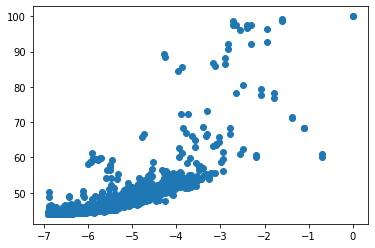

In [32]:
plt.scatter(-np.log(df['publications']), df['score'])

得分`score`与影响力`influence`的关系：

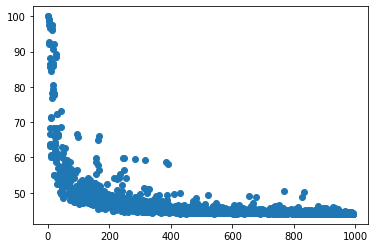

In [33]:
plt.scatter(df['influence'], df['score'])

负对数变换后：

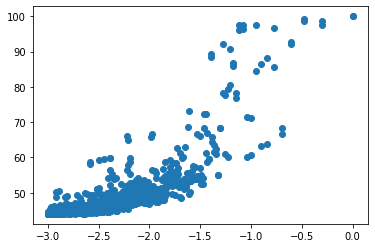

In [34]:
plt.scatter(-np.log10(df['influence']), df['score'])

得分`score`与引用数量`ciations`的关系：

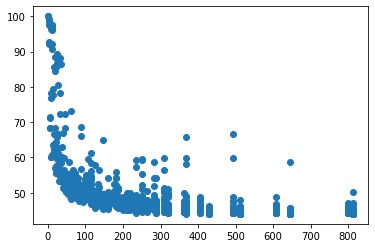

In [35]:
plt.scatter(df['citations'], df['score'])

负对数变换：

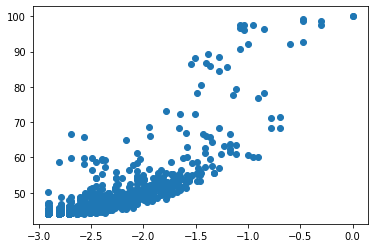

In [36]:
plt.scatter(-np.log10(df['citations']), df['score'])

`score`与`broad_impact`:

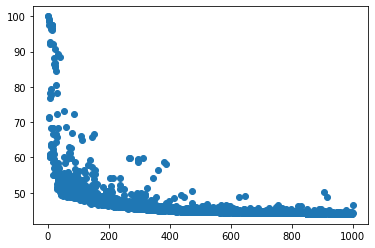

In [37]:
plt.scatter(df['broad_impact'], df['score'])

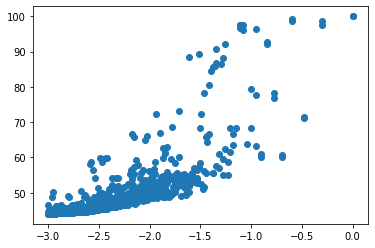

In [38]:
plt.scatter(-np.log10(df['broad_impact']), df['score'])

`score`与`patents`:

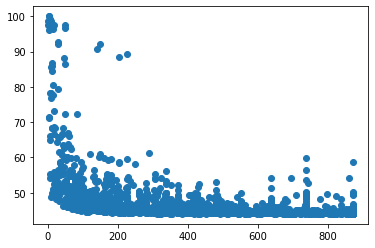

In [39]:
plt.scatter(df['patents'], df['score'])

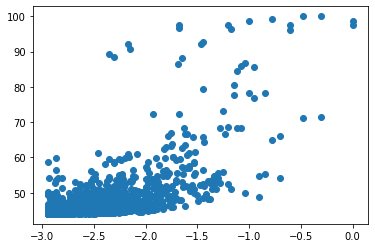

In [40]:
plt.scatter(-np.log10(df['patents']), df['score'])

In [41]:
features = num_feats

按8:2随机划分数据集

In [42]:
X, y = df[features], df['score']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print('Training set, X: %s, y: %s' % (x_train.shape, y_train.shape))
print('Test set,     X: %s, y: %s' % (x_test.shape, y_test.shape))

Training set, X: (1600, 8), y: (1600,)
Test set,     X: (400, 8), y: (400,)


`RMSE`作为评价指标，使用测试集评估模型

In [43]:
def rmse(y_ture, y_pred):
    return np.sqrt(mean_squared_error(y_ture, y_pred))

线性模型

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [45]:
class NegLogTransform(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return -np.log10(X[self.features])

In [46]:
pipe = Pipeline([
    ('neg-log-transform', NegLogTransform(num_feats)),
    ('model', LinearRegression())
])

In [47]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('neg-log-transform',
                 NegLogTransform(features=['quality_of_education',
                                           'alumni_employment',
                                           'quality_of_faculty', 'publications',
                                           'influence', 'citations',
                                           'broad_impact', 'patents'])),
                ('model', LinearRegression())])

In [48]:
y_pred = pipe.predict(x_train)

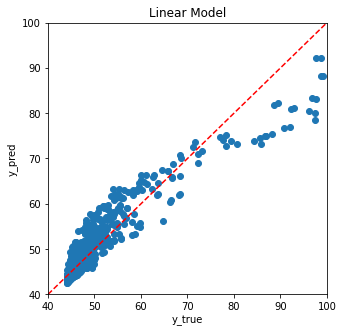

In [49]:
_, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.scatter(y_train, y_pred)
plt.plot([0, 1], [0, 1], ls="--", c="red")
plt.title('Linear Model')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.xlim(40, 100)
plt.ylim(40, 100)
plt.show()

In [50]:
coefs = pd.DataFrame({'Coefficients:': pipe['model'].coef_}, index=features)
coefs

,Coefficients:
quality_of_education,2.641908
alumni_employment,4.467848
quality_of_faculty,12.200436
publications,-0.291167
influence,0.743872
citations,0.136594
broad_impact,1.899212
patents,1.574848


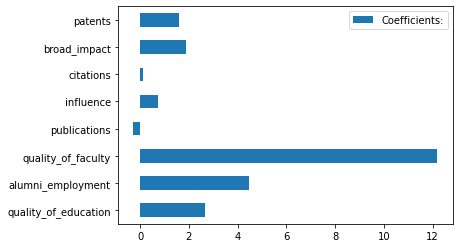

In [51]:
coefs.plot(kind='barh')

**测试集**

In [52]:
y_pred = pipe.predict(x_test)

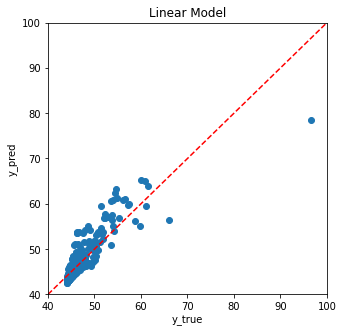

In [53]:
_, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], ls="--", c="red")
plt.title('Linear Model')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.xlim(40, 100)
plt.ylim(40, 100)
plt.show()

In [54]:
print('Test set RMSE: %.4f' % rmse(y_test, y_pred))

Test set RMSE: 2.1882
